# Examples of generating a request sequence
## - using the WorkloadFit class

Read data 
 * Log data for neuroscience applications
 * Array of past execution times

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st

import WorkloadFit
import OptimalSequence

In [4]:
bins=100

# Log data

`cost_model = WorkloadFit.LogDataCost(data)`

- using the discrete data
- using both interpolation models (polynomial and distribution) to go through a continuous fit

In [5]:
dataset = "ACCRE/dtiQA_v2.out"
data = np.loadtxt(dataset, delimiter=' ')
print("Total entries in the historic data: %d" %(len(data)))

Total entries in the historic data: 5276


In [6]:
wf = WorkloadFit.WorkloadFit(data, bins=bins)
discrete_sequence = wf.compute_discrete_sequence()
print("Discrete sequence: %s" %(discrete_sequence))

Discrete sequence: [(129614.0,), (148864.0,), (172825.0,)]


In [7]:
wf.set_interpolation_model([WorkloadFit.PolyInterpolation(max_order=10),
                            WorkloadFit.DistInterpolation()])
sequence = wf.compute_interpolation_sequence()
print("Best fit sequence: %s" %(sequence))

Best fit sequence: [(112777.054,), (152173.59,), (172825.0,)]


In [6]:
# compute the sequence when checkpoints are taken before the reservation end
wf.change_default_sequence_model(OptimalSequence.CheckpointSequence)
wf.set_interpolation_model([WorkloadFit.DistInterpolation()])
check_sequence = wf.compute_interpolation_sequence()
print("Best fit sequence (with checkpoints): %s" %(check_sequence))

Best fit sequence (with checkpoints): [(172825.0, 1)]


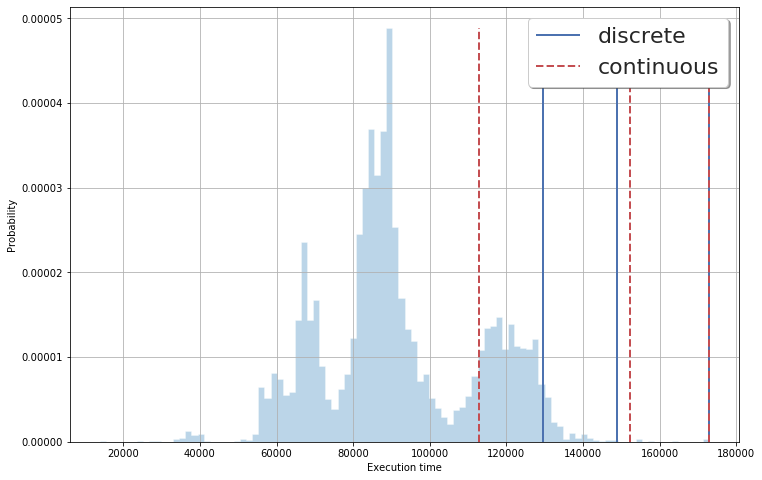

In [8]:
y, x = np.histogram(data, bins=bins, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax.hist(data, bins=bins, density=True, histtype='stepfilled', alpha=0.3)

ax.vlines(discrete_sequence[0], min(y), max(y), colors='b', lw=2,
          linestyles='solid', label='discrete')
for i in range(1,len(discrete_sequence)):
    ax.vlines(discrete_sequence[i], min(y), max(y), colors='b', lw=2, linestyles='solid')

ax.vlines(sequence[0], min(y), max(y), colors='r', linestyles='dashed', lw=2, label='continuous')
for i in range(1,len(sequence)):
    ax.vlines(sequence[i], min(y), max(y), colors='r', linestyles='dashed', lw=2)
#ax.vlines(max(data), min(y), max(y), colors='k', linestyles='solid')

ax.legend(shadow=True)
plt.grid(True)
ax.set_xlabel('Execution time')
ax.set_ylabel('Probability')
plt.show()